# Neural Networks

Chapter 18 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do) on neural networks. Joel's code: [neural_networks.py](https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/neural_networks.py).

In [78]:
import math
import os
import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt

In [50]:
book_dir = Path().resolve().parent.as_posix()
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8,16])

In [51]:
from vector import dot, vector_add

## Perceptron

In [52]:
def step_function(x):
    return 1 if x >= 0 else 0

In [53]:
def perceptron(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    return step_function(dot(weights, x) + bias)

### AND

In [54]:
weights = [2, 2]
bias = -3
perceptron(weights, bias, [1, 1])

1

### OR

In [55]:
weights = [2, 2]
bias = -1
perceptron(weights, bias, [0, 1])

1

## Feed-Forward Neural Net

In [56]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

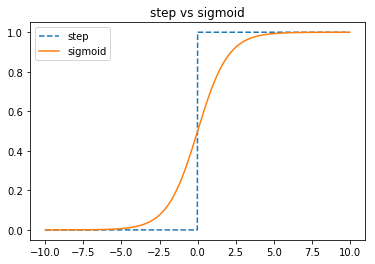

In [65]:
z = [zi/50 - 10 for zi in range(1000)]
plt.plot(z, [step_function(zi) for zi in z], '--', label='step')
plt.plot(z, [sigmoid(zi) for zi in z], label='sigmoid')
plt.title('step vs sigmoid')
plt.legend()
plt.show()

In [66]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

In [70]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""
    
    outputs = []
    
    for layer in neural_network:
        input_with_bias = input_vector + [1]
        output = [neuron_output(neuron, input_with_bias)
                  for neuron in layer]
        outputs.append(output)
        
        # the input to the next layer is the output of this one
        input_vector = output
    
    return outputs

In [71]:
xor_network = [
    [[20, 20, -30], [20, 20, -10]],
    [[-60, 60, -30]]
]

In [74]:
outputs = feed_forward(xor_network,[0, 1])
outputs

[[4.5397868702434395e-05, 0.9999546021312976], [0.9999999999999059]]

In [72]:
for x in [0,1]:
    for y in [0,1]:
        print(x, y, feed_forward(xor_network,[x, y])[-1])

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


## Backpropagation

In [90]:
def backpropagate(network, input_vector, targets):
    """
    Adjust the weights in the network in place based on a single
    labeled training example.
    """
    hidden_outputs, outputs = feed_forward(network, input_vector)
    
    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target)
                     for output, target in zip(outputs, targets)]
    
    # adjust weights for output layer, one neuron at a time
    for i, output_neuron in enumerate(network[-1]):

        # focus on the ith output layer neuron
        for j, hidden_output in enumerate(hidden_outputs + [1]):

            # adjust the jth weight based on both
            # this neuron's delta and its jth input
            output_neuron[j] -= output_deltas[i] * hidden_output
    
    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                         dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer, one neuron at a time
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

### train XOR

randomly initialize

In [108]:
nn = [
    [[random.normalvariate(0, 1/3), random.normalvariate(0, 1/3), random.normalvariate(0, 1/3)],
     [random.normalvariate(0, 1/3), random.normalvariate(0, 1/3), random.normalvariate(0, 1/3)]],
    [[random.normalvariate(0, 1/3), random.normalvariate(0, 1/3), random.normalvariate(0, 1/3)]]
]

train network

In [109]:
training_set = [
    [[0,0], [0]],
    [[0,1], [1]],
    [[1,0], [1]],
    [[1,1], [0]]    
]

In [110]:
for _ in range(10000):
    for input_vector, targets in random.sample(training_set, len(training_set)):
        backpropagate(nn, input_vector, targets)

In [111]:
nn

[[[6.852486545259151, 6.844744503980517, -3.0829434118452386],
  [4.800550076303837, 4.798830831589406, -7.362214269943774]],
 [[10.277322570253569, -11.027195252727264, -4.769477585907083]]]

Predict

In [112]:
for input_vector, targets in training_set:
    output = feed_forward(nn, input_vector)
    print(input_vector, output[-1])

[0, 0] [0.013045785171948064]
[0, 1] [0.9888555179079053]
[1, 0] [0.9888610229899293]
[1, 1] [0.011476679784703119]


...it works!